### Introduction
Artificial neural networks are widely-used tools in machine learning due to their capacity to learn to approximate arbitrary functions.
This function approximation is achieved by performing weighted sums of activities in a 'hidden layer' of neurons, where these weights are most often learned.
While this mimics how learning happens in natural intelligences, biological systems also involve neuromodulation that enables restructuring of neural dynamics. Effectively, this means that biological networks have several dynamic "operating points". 
In this notebook I evaluate a potential computational role for this neuromodulation.

### Theory

A function of the input $x$, $f(x)$ can be approximated by a weighted sum of activities $\boldsymbol{a}$:

$
\hat f(x) = \sum_{n=1}^N d_n a_n(x_k)
$

where $a_n$ is the activity of the $n^{\textrm{th}}$ neuron, and $d_n$ is the optimal decoding weight associated with it. In other words $f(x) \approx \boldsymbol{d} \cdot \boldsymbol{a}$. These decoding weights are those that minimize the approximation error $ \epsilon = \frac{1}{K}\sum_{k=1}^K ||f(x_k) - \sum_{n=1}^N d_n a_n(x_k)||^2.$

To decode distinct functions, $f_1(x)$ and $f_2(x)$, with a common set of decoding weights, we desire situations that induce decorrelated activities in the hidden layer, that is:

$
a(x,s_1) \cdot a(x,s_2) \approx 0. 
$

Many neuromodulators have their effect by increasing the firing rate of their targets. This suggests that they do not affect the neural representation (by changing their preferred directions), but instead position neurons to overcome their biases.
I hypothesize that this mechanism exploits firing rate saturation to decorrelate neural activities across situations and achieve decoding of multiple functions from a single population of neurons.
In this notebook I evaluate the extent to which it is possible to decode multiple functions from a single population of neurons with fixed representations across conditions.

In [12]:
# import libraries

import matplotlib.pyplot as plt
import numpy as np
import nengo

In [13]:
# specify the functions in two different conditions

def func1(x):
    return x

def func2(x):
    return -x

# sample from the functions
xs1 = np.random.uniform( -1, 0.1, size=(1000,) )
xs2 = np.random.uniform( -0.1, 1, size=(1000,) )
ys1 = func1(xs1)
ys2 = func2(xs2)

ys = np.hstack([ys1,ys2]).reshape(-1,1)
xs = np.hstack([xs1,xs2]).reshape(-1,1)

In [16]:
n_neurons = 2000
intercepts = np.clip( np.random.beta(a = 0.2, b = 0.2,size=(n_neurons,)),a_min = 0, a_max = 1)
#intercepts = np.random.uniform(-1,1,size=(n_neurons,)),

neuron_type = nengo.Tanh()
stim_transform = 0.2

In [17]:
with nengo.Network() as model:
    
    stim = nengo.Node( nengo.processes.WhiteSignal(1., high=10, seed=42) )
    inj = nengo.Node( lambda t: ( t // 1. - 10.) / 10. )
    #inj = nengo.Node( [0] )
    ens = nengo.Ensemble(
                n_neurons = n_neurons,
                dimensions = 1,
                radius = 1,
        
                neuron_type = neuron_type,
                intercepts = intercepts,

                )
    out = nengo.Node( size_in = 1 )
    
    nengo.Connection( inj, ens )
    nengo.Connection( stim, ens, transform = stim_transform )
    nengo.Connection( ens, out, eval_points = xs, function = ys )
    
    stim_p = nengo.Probe( stim )
    ens_p = nengo.Probe( ens )
    inj_p = nengo.Probe( inj )
    out_p = nengo.Probe( out )

sim = nengo.Simulator(model,dt = 0.01)
sim.run(20)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

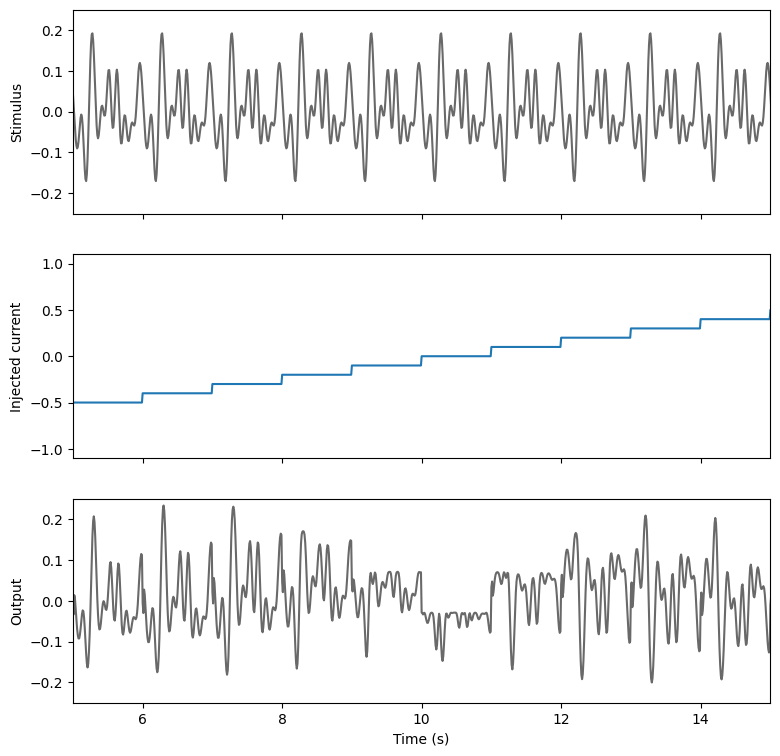

In [18]:
import pandas as pd
df = pd.DataFrame( data = {
    'time' : sim.trange(),
    'stim' : sim.data[stim_p].flatten(),
    'inj'  : sim.data[inj_p].flatten(),
    'out'  : sim.data[out_p].flatten()
    }
)

# print(df.head(20))

fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(9.,9.),sharex=True)
ax1.plot(df['time'],df['stim']*stim_transform,color='dimgray',label='stim')
ax1.set_ylabel('Stimulus')
ax2.plot(df['time'],df['inj'])
ax2.set_ylabel('Injected current')
ax3.plot(df['time'],df['out']+df['inj'].abs(),color='dimgray',label='output')
ax3.set_ylabel('Output')

for ax in (ax1,ax3):
    #ax.legend(loc='upper right')
    ax.set_xlim(5.,15.)
    ax.set_ylim(-0.25,0.25)
ax3.set_xlabel('Time (s)')
plt.show()

In [19]:
import nengo_gui.jupyter
nengo_gui.jupyter.InlineGUI(model, cfg='neuromodulating_functions.cfg')